In [1]:
!pip install xlrd

In [2]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [3]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install bayesian-optimization

In [5]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

Días      Área  PY_VC_PCA  Valor_Proyecto
#                                                 
1    0.199969 -0.224328  -0.670771       -0.563421
2    0.199969 -0.224328  -0.670771       -0.545120
3    0.199969 -0.222966  -0.670771       -0.544601
4    0.199969 -0.222966  -0.670771       -0.532932
5    1.478731 -0.182279  -0.670771       -0.532623
..        ...       ...        ...             ...
121 -0.699160 -0.219754  -1.883419       -0.617652
122 -0.659199 -0.223679  -1.883419       -0.604545
123 -0.579276 -0.224410  -1.883419       -0.584883
124 -0.898967 -0.074911  -1.932311       -0.488695
125  0.080085 -0.203695  -0.670771        1.333930

[115 rows x 4 columns]

In [6]:
PY_DATOS_REALES_EST_SA.describe()

Días        Área   PY_VC_PCA  Valor_Proyecto
count  115.000000  115.000000  115.000000      115.000000
mean    -0.082193   -0.098454   -0.089025       -0.097465
std      0.780387    0.605987    1.861373        0.706249
min     -0.918948   -0.224417   -1.932311       -0.682176
25%     -0.669189   -0.224096   -1.883419       -0.587202
50%     -0.359489   -0.222363   -0.670771       -0.410561
75%      0.219950   -0.203633    0.739387        0.150954
max      3.576699    4.300396    3.524117        2.571424

In [7]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, units_3, units_4, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_4), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Usar Huber como pérdida y agregar Huber Loss como métrica
    model.compile(optimizer=RMSprop(learning_rate),
                  loss=tf.keras.losses.Huber(), #----------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #----------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,   #---------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, units_3, units_4, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, units_3, units_4, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'units_3': (5, 100),
    'units_4': (5, 100),
    'learning_rate': (0.0001, 0.1)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=2, n_iter=20) #---------------20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))
best_params['units_3'] = int(round(best_params['units_3']))
best_params['units_4'] = int(round(best_params['units_4']))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['units_3'],
    best_params['units_4'],
    best_params['learning_rate']
)

|   iter    |  target   | learni... |  units_1  |  units_2  |  units_3  |  units_4  |
-------------------------------------------------------------------------------------
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.8197 - loss: 1.0035 - mae: 1.2877 - mse: 2.0819 - pearson_correlation: 3.8490e-16 - r2_keras: -282.4411 - rmse: 1.4651 - sae: 5180.3682 - sse: 8791.9893
Epoch 1: val_loss improved from inf to 5.96612, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - huber_loss: 1.0175 - loss: 1.1602 - mae: 1.4081 - mse: 2.6610 - pearson_correlation: 2.3055e-16 - r2_keras: -302.8897 - rmse: 1.7338 - sae: 3956.6775 - sse: 7209.4463 - val_huber_loss: 5.5541 - val_loss: 5.9661 - val_mae: 6.0364 - val_mse: 50.0093 - val_pearson_correlation: -1.5821e-16 - val_r2_keras: -1840.0386 - val_rmse: 6.9872 - val_sae: 3175.1758 - val_sse: 25826.2891 - learning_rate: 0.0375
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 0.9117 - loss: 1.3237 - mae: 1.3594 - mse: 2.7916 - pearson_correlation: -2.9968e-16 - r2_keras: -489.9541 - rmse: 1.9282 - sae: 6126.4961 - sse: 15228.7832
Epoch 2: val_loss improved from 5.96612 to 0.90690,

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.6276 - loss: 0.8171 - mae: 1.0237 - mse: 2.3952 - pearson_correlation: 1.5536e-16 - r2_keras: -288.6647 - rmse: 1.4811 - sae: 3622.6450 - sse: 8985.0371
Epoch 1: val_loss improved from inf to 1.35887, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - huber_loss: 0.6811 - loss: 0.8529 - mae: 1.0555 - mse: 2.4116 - pearson_correlation: 1.3027e-16 - r2_keras: -276.7906 - rmse: 1.6373 - sae: 2791.3635 - sse: 6983.3330 - val_huber_loss: 1.1487 - val_loss: 1.3589 - val_mae: 1.5969 - val_mse: 3.9419 - val_pearson_correlation: 1.3928e-16 - val_r2_keras: -100.7472 - val_rmse: 1.6426 - val_sae: 686.4037 - val_sse: 1427.3209 - learning_rate: 0.0112
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - huber_loss: 0.7603 - loss: 0.9704 - mae: 1.1876 - mse: 1.9909 - pearson_correlation: -2.6300e-16 - r2_keras: -185.7739 - rmse: 1.1893 - sae: 3948.7241 - sse: 5793.4917
Epoch 2: val_loss improved from 1.35887 to 0.50101, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8831 - loss: 1.0447 - mae: 1.3022 - mse: 2.8861 - pearson_correlation: 2.2864e-18 - r2_keras: -309.9783 - rmse: 1.5346 - sae: 4822.0308 - sse: 9646.1582
Epoch 1: val_loss improved from inf to 22.54705, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - huber_loss: 1.6952 - loss: 1.5882 - mae: 1.8054 - mse: 6.9792 - pearson_correlation: -4.3956e-17 - r2_keras: -741.4213 - rmse: 2.6567 - sae: 4237.9062 - sse: 12707.5420 - val_huber_loss: 22.0218 - val_loss: 22.5471 - val_mae: 22.5214 - val_mse: 751.1561 - val_pearson_correlation: -9.8623e-17 - val_r2_keras: -28633.1406 - val_rmse: 27.5558 - val_sae: 12104.2500 - val_sse: 401682.8438 - learning_rate: 0.0521
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - huber_loss: 4.2934 - loss: 4.8186 - mae: 4.7799 - mse: 34.1646 - pearson_correlation: 8.8588e-16 - r2_keras: -4114.8037 - rmse: 5.5829 - sae: 18437.2090 - sse: 127667.0781
Epoch 2: val_loss improved from 22.54

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4094 - loss: 0.5953 - mae: 0.7226 - mse: 1.1566 - pearson_correlation: 1.6241e-16 - r2_keras: -181.0682 - rmse: 1.1742 - sae: 3299.1860 - sse: 5647.5269
Epoch 1: val_loss improved from inf to 2.24826, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - huber_loss: 1.1334 - loss: 1.0426 - mae: 1.1969 - mse: 3.7901 - pearson_correlation: 1.3733e-16 - r2_keras: -480.2783 - rmse: 2.1226 - sae: 3051.4155 - sse: 7986.6523 - val_huber_loss: 2.0159 - val_loss: 2.2483 - val_mae: 2.4607 - val_mse: 9.6560 - val_pearson_correlation: -1.6625e-16 - val_r2_keras: -358.9928 - val_rmse: 3.0897 - val_sae: 1276.1204 - val_sse: 5050.0181 - learning_rate: 0.0161
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - huber_loss: 2.3697 - loss: 2.6020 - mae: 2.8357 - mse: 11.6572 - pearson_correlation: -3.0983e-16 - r2_keras: -1353.7932 - rmse: 3.2031 - sae: 10929.6016 - sse: 42023.9922
Epoch 2: val_loss improved from 2.24826 to 1.33432,

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.2472 - loss: 1.4095 - mae: 1.7090 - mse: 3.7268 - pearson_correlation: -2.2441e-16 - r2_keras: -342.1993 - rmse: 1.6121 - sae: 5551.1523 - sse: 10645.6143
Epoch 1: val_loss improved from inf to 50.39930, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - huber_loss: 3.5496 - loss: 2.8726 - mae: 3.1171 - mse: 26.8305 - pearson_correlation: -1.9731e-16 - r2_keras: -2990.9268 - rmse: 4.7870 - sae: 6026.7334 - sse: 39508.6562 - val_huber_loss: 49.8225 - val_loss: 50.3993 - val_mae: 50.3207 - val_mse: 6195.8398 - val_pearson_correlation: -2.2441e-16 - val_r2_keras: -235226.8906 - val_rmse: 78.9798 - val_sae: 26802.7715 - val_sse: 3299802.5000 - learning_rate: 0.0572
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - huber_loss: 3.8199 - loss: 4.3967 - mae: 4.3100 - mse: 28.5382 - pearson_correlation: -3.2748e-16 - r2_keras: -3793.4070 - rmse: 5.3605 - sae: 18257.6719 - sse: 117697.7578
Epoch 2: val_loss improved fr

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.2769 - loss: 0.3699 - mae: 0.5506 - mse: 0.6473 - pearson_correlation: 2.4364e-16 - r2_keras: -168.8765 - rmse: 1.1342 - sae: 3456.7739 - sse: 5269.3564
Epoch 1: val_loss improved from inf to 128.05600, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - huber_loss: 3.8442 - loss: 2.6014 - mae: 2.7679 - mse: 33.9279 - pearson_correlation: 1.8389e-16 - r2_keras: -3618.9172 - rmse: 4.9381 - sae: 5237.7666 - sse: 44646.2188 - val_huber_loss: 127.4801 - val_loss: 128.0560 - val_mae: 127.9801 - val_mse: 28127.7930 - val_pearson_correlation: 2.9167e-16 - val_r2_keras: -1064641.0000 - val_rmse: 168.0249 - val_sae: 67945.3828 - val_sse: 14934914.0000 - learning_rate: 0.0847
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - huber_loss: 8.2676 - loss: 8.8435 - mae: 8.7652 - mse: 110.7131 - pearson_correlation: 2.1772e-16 - r2_keras: -14879.3613 - rmse: 10.6155 - sae: 36044.5625 - sse: 461570.1875
Epoch 2: val_loss impro

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6030 - loss: 0.8142 - mae: 0.9632 - mse: 1.6782 - pearson_correlation: 1.2291e-16 - r2_keras: -229.0956 - rmse: 1.3200 - sae: 4104.6904 - sse: 7137.2773
Epoch 1: val_loss improved from inf to 15.83427, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - huber_loss: 2.0700 - loss: 1.7502 - mae: 1.8789 - mse: 11.8237 - pearson_correlation: 1.0387e-16 - r2_keras: -1431.4988 - rmse: 3.4057 - sae: 4244.7017 - sse: 19762.0918 - val_huber_loss: 15.3331 - val_loss: 15.8343 - val_mae: 15.8331 - val_mse: 350.5688 - val_pearson_correlation: -1.6947e-16 - val_r2_keras: -12656.6494 - val_rmse: 18.3210 - val_sae: 8130.9229 - val_sse: 177562.8750 - learning_rate: 0.0389
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - huber_loss: 2.3510 - loss: 2.8522 - mae: 2.8204 - mse: 11.4720 - pearson_correlation: -3.1080e-16 - r2_keras: -1247.1526 - rmse: 3.0744 - sae: 10448.0869 - sse: 38716.1328
Epoch 2: val_loss improved from 15.83

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.9860 - loss: 1.1568 - mae: 1.3741 - mse: 3.3673 - pearson_correlation: -2.0617e-16 - r2_keras: -407.8226 - rmse: 1.7595 - sae: 5677.4238 - sse: 12681.1660
Epoch 1: val_loss improved from inf to 3.53188, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - huber_loss: 1.6221 - loss: 1.5470 - mae: 1.7747 - mse: 6.2336 - pearson_correlation: -1.1139e-16 - r2_keras: -712.0497 - rmse: 2.6552 - sae: 4682.4307 - sse: 13621.2061 - val_huber_loss: 3.3398 - val_loss: 3.5319 - val_mae: 3.8201 - val_mse: 22.8236 - val_pearson_correlation: -1.1257e-16 - val_r2_keras: -973.4274 - val_rmse: 5.0833 - val_sae: 2248.6873 - val_sse: 13669.3740 - learning_rate: 0.0129
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - huber_loss: 1.8489 - loss: 2.0410 - mae: 2.3128 - mse: 8.1766 - pearson_correlation: -1.5728e-16 - r2_keras: -1089.5667 - rmse: 2.8738 - sae: 9792.1719 - sse: 33828.0117
Epoch 2: val_loss improved from 3.53188 to 1.07

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.3904 - loss: 0.5062 - mae: 0.6962 - mse: 0.9843 - pearson_correlation: 2.2243e-16 - r2_keras: -179.2625 - rmse: 1.1684 - sae: 3491.2710 - sse: 5591.5171
Epoch 1: val_loss improved from inf to 93.87486, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - huber_loss: 2.5004 - loss: 1.8715 - mae: 2.0183 - mse: 15.1582 - pearson_correlation: 2.3191e-16 - r2_keras: -1714.6237 - rmse: 3.5997 - sae: 4241.9517 - sse: 22442.3438 - val_huber_loss: 93.1298 - val_loss: 93.8749 - val_mae: 93.6290 - val_mse: 12195.0059 - val_pearson_correlation: -1.4693e-16 - val_r2_keras: -462446.0938 - val_rmse: 110.7395 - val_sae: 49709.0625 - val_sse: 6487258.0000 - learning_rate: 0.0969
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - huber_loss: 8.6578 - loss: 9.4029 - mae: 9.1547 - mse: 120.1859 - pearson_correlation: 5.8341e-16 - r2_keras: -15992.5166 - rmse: 11.0054 - sae: 37554.5352 - sse: 496098.8750
Epoch 2: val_loss improved f

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.4988 - loss: 0.6701 - mae: 0.9106 - mse: 1.1695 - pearson_correlation: 9.0619e-17 - r2_keras: -217.2796 - rmse: 1.2857 - sae: 4368.3701 - sse: 6770.7612
Epoch 1: val_loss improved from inf to 2.67611, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - huber_loss: 1.9756 - loss: 1.5714 - mae: 1.8238 - mse: 8.4344 - pearson_correlation: -7.7073e-17 - r2_keras: -887.9510 - rmse: 2.7827 - sae: 4247.9800 - sse: 13234.3145 - val_huber_loss: 2.4872 - val_loss: 2.6761 - val_mae: 2.9779 - val_mse: 11.1294 - val_pearson_correlation: -3.4495e-16 - val_r2_keras: -534.3612 - val_rmse: 3.7679 - val_sae: 1827.6565 - val_sse: 7510.1050 - learning_rate: 0.0111
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - huber_loss: 1.4202 - loss: 1.6091 - mae: 1.8096 - mse: 5.0760 - pearson_correlation: 1.3491e-16 - r2_keras: -860.1329 - rmse: 2.5537 - sae: 8434.1504 - sse: 26711.2656
Epoch 2: val_loss improved from 2.67611 to 0.45362, 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - huber_loss: 0.7468 - loss: 0.9520 - mae: 1.1959 - mse: 2.0759 - pearson_correlation: -3.7370e-16 - r2_keras: -202.2502 - rmse: 1.2406 - sae: 4106.1201 - sse: 6304.5684
Epoch 1: val_loss improved from inf to 2.49373, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - huber_loss: 0.7950 - loss: 0.9830 - mae: 1.2158 - mse: 2.1862 - pearson_correlation: -6.3160e-17 - r2_keras: -227.2834 - rmse: 1.5073 - sae: 3173.9773 - sse: 5291.3960 - val_huber_loss: 2.2785 - val_loss: 2.4937 - val_mae: 2.7731 - val_mse: 8.9567 - val_pearson_correlation: -3.0077e-17 - val_r2_keras: -251.3197 - val_rmse: 2.5867 - val_sae: 1248.6801 - val_sse: 3539.5679 - learning_rate: 0.0076
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - huber_loss: 1.5740 - loss: 1.7893 - mae: 2.0502 - mse: 5.6944 - pearson_correlation: 5.4005e-16 - r2_keras: -555.3751 - rmse: 2.0527 - sae: 7093.3018 - sse: 17258.0586
Epoch 2: val_loss improved from 2.49373 to 0.83014, s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.6818 - loss: 0.7684 - mae: 1.0580 - mse: 1.9996 - pearson_correlation: -1.1359e-16 - r2_keras: -260.2230 - rmse: 1.4065 - sae: 4389.3525 - sse: 8102.8096
Epoch 1: val_loss improved from inf to 28.74995, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - huber_loss: 1.4685 - loss: 1.3108 - mae: 1.5596 - mse: 4.6579 - pearson_correlation: -1.2295e-16 - r2_keras: -501.2324 - rmse: 2.2168 - sae: 3807.1565 - sse: 9250.3066 - val_huber_loss: 28.2567 - val_loss: 28.7500 - val_mae: 28.7567 - val_mse: 1458.7505 - val_pearson_correlation: -2.4092e-17 - val_r2_keras: -55681.9648 - val_rmse: 38.4267 - val_sae: 15329.0820 - val_sse: 781126.6875 - learning_rate: 0.0942
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - huber_loss: 0.9470 - loss: 1.4403 - mae: 1.3290 - mse: 3.8685 - pearson_correlation: 1.3571e-17 - r2_keras: -484.5039 - rmse: 1.9175 - sae: 5078.0225 - sse: 15059.7227
Epoch 2: val_loss improved from 28.74995

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.8409 - loss: 0.9996 - mae: 1.2857 - mse: 2.2625 - pearson_correlation: -3.7991e-16 - r2_keras: -301.6254 - rmse: 1.5139 - sae: 5386.0796 - sse: 9387.0615
Epoch 1: val_loss improved from inf to 61.49158, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - huber_loss: 3.5473 - loss: 2.7676 - mae: 2.9438 - mse: 29.1307 - pearson_correlation: -2.5753e-16 - r2_keras: -3271.9202 - rmse: 4.9229 - sae: 6093.5503 - sse: 42282.9688 - val_huber_loss: 60.5716 - val_loss: 61.4916 - val_mae: 61.0716 - val_mse: 6282.8887 - val_pearson_correlation: -1.3462e-17 - val_r2_keras: -235054.5156 - val_rmse: 78.9509 - val_sae: 32062.9355 - val_sse: 3297384.2500 - learning_rate: 0.0742
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 5.4897 - loss: 6.4097 - mae: 5.9337 - mse: 75.9973 - pearson_correlation: 1.0017e-17 - r2_keras: -9787.9961 - rmse: 8.6100 - sae: 23870.0566 - sse: 303642.4062
Epoch 2: val_loss improved from

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 1.0422 - loss: 1.2679 - mae: 1.5256 - mse: 3.1283 - pearson_correlation: -5.5365e-16 - r2_keras: -395.8168 - rmse: 1.7335 - sae: 6190.4326 - sse: 12308.7617
Epoch 1: val_loss improved from inf to 273.18967, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - huber_loss: 3.5141 - loss: 3.0612 - mae: 3.0304 - mse: 22.6264 - pearson_correlation: -3.0709e-16 - r2_keras: -2574.3311 - rmse: 4.5504 - sae: 6516.4482 - sse: 35311.4453 - val_huber_loss: 271.1738 - val_loss: 273.1897 - val_mae: 271.6738 - val_mse: 100828.1328 - val_pearson_correlation: 4.3525e-17 - val_r2_keras: -3804099.2500 - val_rmse: 317.6126 - val_sae: 143708.5781 - val_sse: 53364332.0000 - learning_rate: 0.0929
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - huber_loss: 14.5510 - loss: 16.5669 - mae: 15.0409 - mse: 348.2991 - pearson_correlation: -6.9692e-17 - r2_keras: -45708.1367 - rmse: 18.6052 - sae: 60831.0625 - sse: 1417840.2500
Epoch 2: val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.6520 - loss: 0.7354 - mae: 1.0101 - mse: 1.6227 - pearson_correlation: -3.3369e-16 - r2_keras: -175.9337 - rmse: 1.1575 - sae: 3773.2178 - sse: 5488.2637
Epoch 1: val_loss improved from inf to 11.30435, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - huber_loss: 1.6638 - loss: 1.3721 - mae: 1.6539 - mse: 7.1341 - pearson_correlation: -2.6160e-16 - r2_keras: -707.2641 - rmse: 2.4875 - sae: 3595.8362 - sse: 10583.1787 - val_huber_loss: 11.0646 - val_loss: 11.3043 - val_mae: 11.5499 - val_mse: 155.3303 - val_pearson_correlation: -2.1282e-17 - val_r2_keras: -5484.4897 - val_rmse: 12.0609 - val_sae: 5946.2896 - val_sse: 76951.0469 - learning_rate: 0.0705
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - huber_loss: 1.0769 - loss: 1.3166 - mae: 1.5394 - mse: 3.1623 - pearson_correlation: -1.7269e-16 - r2_keras: -447.9213 - rmse: 1.8438 - sae: 6296.5830 - sse: 13924.9766
Epoch 2: val_loss improved from 11.30435 t

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.3603 - loss: 0.5501 - mae: 0.6572 - mse: 1.0000 - pearson_correlation: -3.1585e-16 - r2_keras: -227.7440 - rmse: 1.3162 - sae: 3889.1548 - sse: 7095.3521
Epoch 1: val_loss improved from inf to 185.83235, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - huber_loss: 3.3669 - loss: 2.5795 - mae: 2.5285 - mse: 25.0039 - pearson_correlation: -1.8941e-16 - r2_keras: -2871.6252 - rmse: 4.5606 - sae: 5207.6597 - sse: 36637.4414 - val_huber_loss: 184.0606 - val_loss: 185.8324 - val_mae: 184.5606 - val_mse: 59918.2266 - val_pearson_correlation: 2.2218e-16 - val_r2_keras: -2269900.2500 - val_rmse: 245.3439 - val_sae: 97786.9844 - val_sse: 31842422.0000 - learning_rate: 0.0924
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - huber_loss: 11.1773 - loss: 12.9490 - mae: 11.6726 - mse: 236.2026 - pearson_correlation: -2.7418e-16 - r2_keras: -31858.3281 - rmse: 15.5328 - sae: 47647.6289 - sse: 988236.5000
Epoch 2: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.9259 - loss: 1.0610 - mae: 1.3706 - mse: 2.6635 - pearson_correlation: -3.4936e-16 - r2_keras: -257.9228 - rmse: 1.4003 - sae: 4708.6885 - sse: 8031.4609
Epoch 1: val_loss improved from inf to 29.12310, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - huber_loss: 2.8706 - loss: 2.3620 - mae: 2.5638 - mse: 17.3455 - pearson_correlation: -2.5223e-16 - r2_keras: -1896.1731 - rmse: 3.8662 - sae: 5013.7363 - sse: 25583.4297 - val_huber_loss: 28.2085 - val_loss: 29.1231 - val_mae: 28.7085 - val_mse: 1042.9696 - val_pearson_correlation: 2.5216e-16 - val_r2_keras: -39212.4961 - val_rmse: 32.2470 - val_sae: 15162.5879 - val_sse: 550091.1875 - learning_rate: 0.0890
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - huber_loss: 1.4596 - loss: 2.3742 - mae: 1.9196 - mse: 6.0700 - pearson_correlation: -1.1882e-16 - r2_keras: -669.8519 - rmse: 2.2540 - sae: 7060.3008 - sse: 20808.9883
Epoch 2: val_loss improv

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.9131 - loss: 1.0314 - mae: 1.3962 - mse: 2.5794 - pearson_correlation: 5.0109e-17 - r2_keras: -397.9893 - rmse: 1.7383 - sae: 5934.1553 - sse: 12376.1484
Epoch 1: val_loss improved from inf to 16.51634, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - huber_loss: 2.5495 - loss: 2.0498 - mae: 2.3886 - mse: 14.4733 - pearson_correlation: 1.1040e-16 - r2_keras: -1584.3995 - rmse: 3.7240 - sae: 5568.4585 - sse: 23727.4512 - val_huber_loss: 16.2516 - val_loss: 16.5163 - val_mae: 16.7486 - val_mse: 332.7408 - val_pearson_correlation: -5.4575e-17 - val_r2_keras: -13138.6348 - val_rmse: 18.6665 - val_sae: 9103.9648 - val_sse: 184324.2188 - learning_rate: 0.0383
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - huber_loss: 3.4408 - loss: 3.7055 - mae: 3.8632 - mse: 22.5296 - pearson_correlation: 1.2217e-16 - r2_keras: -3145.8655 - rmse: 4.8817 - sae: 16458.0957 - sse: 97611.8281
Epoch 2: val_loss improved from 16.51

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8840 - loss: 0.9535 - mae: 1.3467 - mse: 2.3759 - pearson_correlation: 4.9210e-16 - r2_keras: -477.8941 - rmse: 1.9044 - sae: 6627.4092 - sse: 14854.6953
Epoch 1: val_loss improved from inf to 5.33033, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step - huber_loss: 0.9139 - loss: 0.9818 - mae: 1.3488 - mse: 2.5533 - pearson_correlation: 2.3895e-16 - r2_keras: -383.4312 - rmse: 1.8397 - sae: 4771.4517 - sse: 10667.5586 - val_huber_loss: 5.1976 - val_loss: 5.3303 - val_mae: 5.6976 - val_mse: 47.6977 - val_pearson_correlation: -5.6276e-17 - val_r2_keras: -2049.7805 - val_rmse: 7.3745 - val_sae: 3236.0176 - val_sse: 28768.5703 - learning_rate: 0.0455
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - huber_loss: 2.0710 - loss: 2.2038 - mae: 2.5385 - mse: 8.4652 - pearson_correlation: 1.1267e-16 - r2_keras: -1441.4409 - rmse: 3.3051 - sae: 11783.0508 - sse: 44742.7148
Epoch 2: val_loss improved from 5.33033 to 0.905

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.4639 - loss: 0.5232 - mae: 0.8208 - mse: 1.5076 - pearson_correlation: -8.6929e-16 - r2_keras: -296.5160 - rmse: 1.5010 - sae: 4222.6206 - sse: 9228.5752
Epoch 1: val_loss improved from inf to 2.35235, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - huber_loss: 0.6909 - loss: 0.6872 - mae: 0.9833 - mse: 1.8706 - pearson_correlation: -6.9390e-16 - r2_keras: -279.4660 - rmse: 1.6407 - sae: 3266.8215 - sse: 7115.6772 - val_huber_loss: 2.1377 - val_loss: 2.3524 - val_mae: 2.4781 - val_mse: 32.2602 - val_pearson_correlation: 4.6009e-17 - val_r2_keras: -1065.4241 - val_rmse: 5.3179 - val_sae: 1350.3163 - val_sse: 14959.9121 - learning_rate: 0.0768
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - huber_loss: 0.2450 - loss: 0.4597 - mae: 0.5603 - mse: 0.6229 - pearson_correlation: 6.6293e-16 - r2_keras: -88.6793 - rmse: 0.8241 - sae: 2610.8306 - sse: 2781.7383
Epoch 2: val_loss improved from 2.35235 to 0.46671, 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - huber_loss: 0.4302 - loss: 0.5563 - mae: 0.7803 - mse: 1.0970 - pearson_correlation: 1.0880e-16 - r2_keras: -181.3656 - rmse: 1.1752 - sae: 3572.6729 - sse: 5656.7520
Epoch 1: val_loss improved from inf to 12.79838, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - huber_loss: 1.3123 - loss: 1.1831 - mae: 1.3390 - mse: 4.7406 - pearson_correlation: 1.0686e-16 - r2_keras: -506.1179 - rmse: 2.1701 - sae: 3284.6411 - sse: 8293.5752 - val_huber_loss: 12.1511 - val_loss: 12.7984 - val_mae: 12.6478 - val_mse: 235.3189 - val_pearson_correlation: 4.6538e-17 - val_r2_keras: -9369.8232 - val_rmse: 15.7638 - val_sae: 6897.0342 - val_sse: 131454.9219 - learning_rate: 0.0918
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - huber_loss: 1.1953 - loss: 1.8426 - mae: 1.5888 - mse: 4.0526 - pearson_correlation: -2.0860e-16 - r2_keras: -695.6725 - rmse: 2.2969 - sae: 7713.7900 - sse: 21609.9082
Epoch 2: val_loss improved from 12.79838 to 4

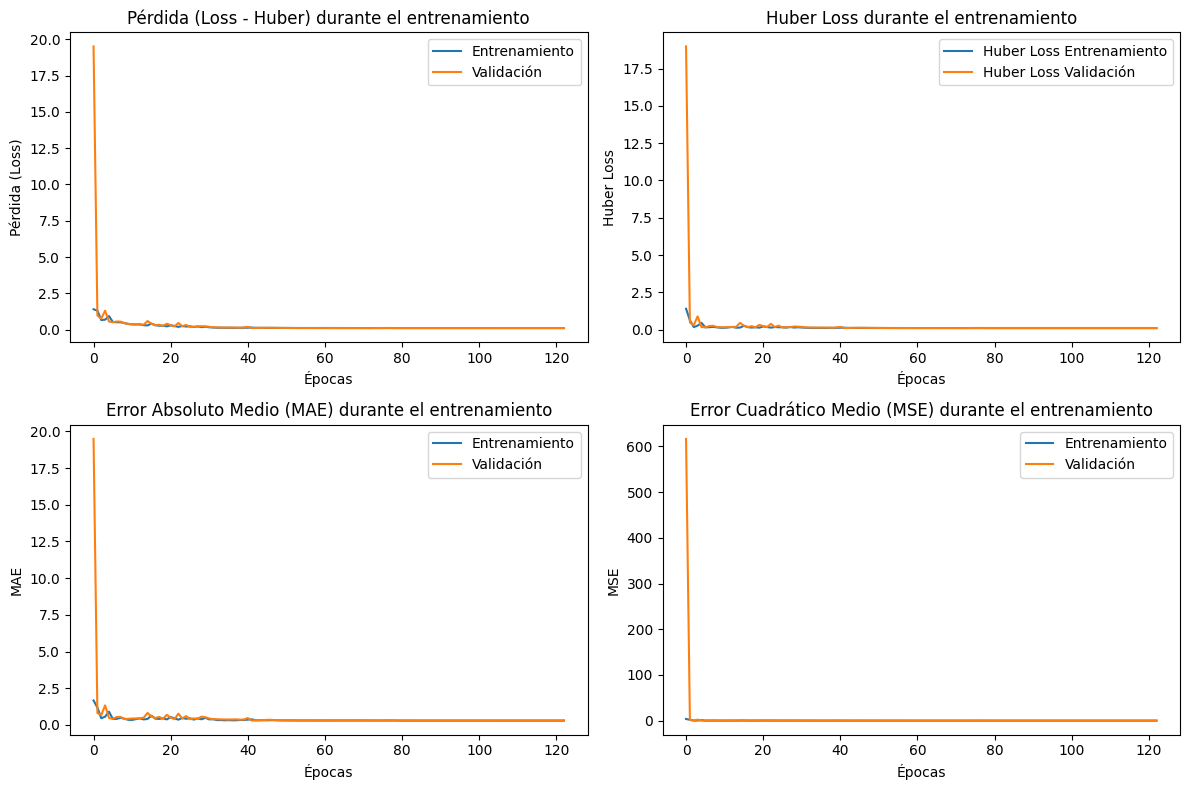

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


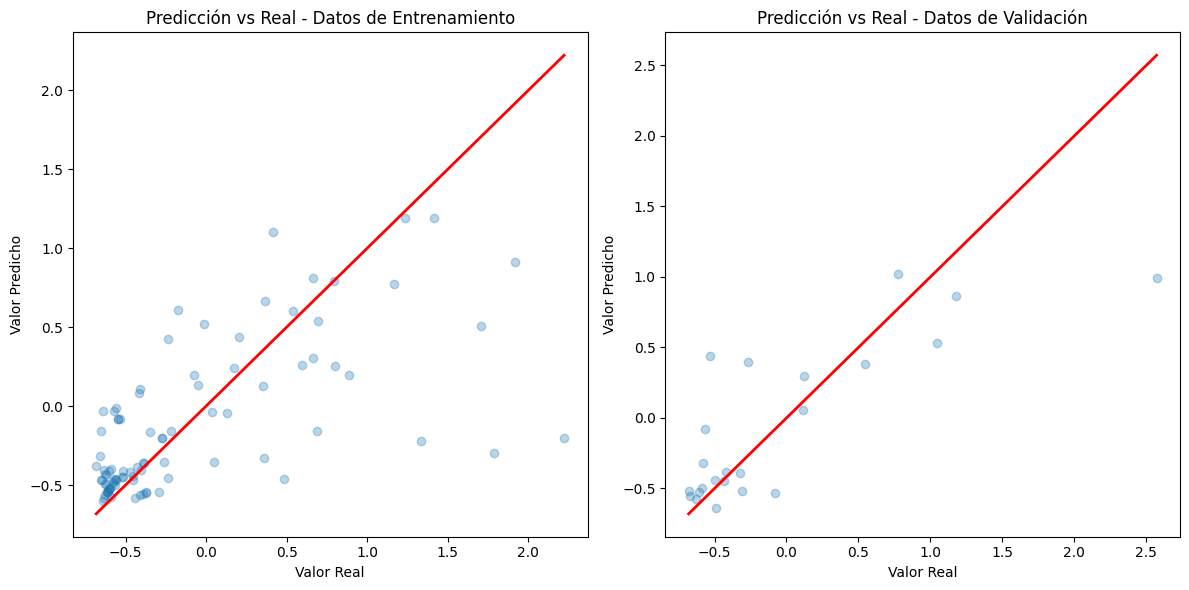


Métricas de entrenamiento:
MSE: 0.26111809310566725
RMSE: 0.5109971556727759
MAE: 0.31127899984785423
R^2: 0.438531420705778
Correlación de Pearson: -1.9201373683752056e-16
Correlación de Spearman: 0.6688629699861577
SSE: 5741.518900607737
SAE: 5035.31583609879
Media del error: 0.03089344974526794
Desviación estándar del error: 0.8230379095766092
Huber Loss (Entrenamiento): 0.0997433289885521

Métricas de validación:
MSE: 0.2167942123212288
RMSE: 0.46561165397918125
MAE: 0.30103378518704005
R^2: 0.644551689666611
Correlación de Pearson: -1.1422050881812917e-17
Correlación de Spearman: 0.7045454545454546
SSE: 477.56722239339604
SAE: 360.48239478785194
Media del error: 0.005724029094575399
Desviación estándar del error: 0.950126735122284
Huber Loss (Validación): 0.10930662602186203
El punto de convergencia (mejor epoch): 73


In [9]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss - Huber) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Validación')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Validación')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


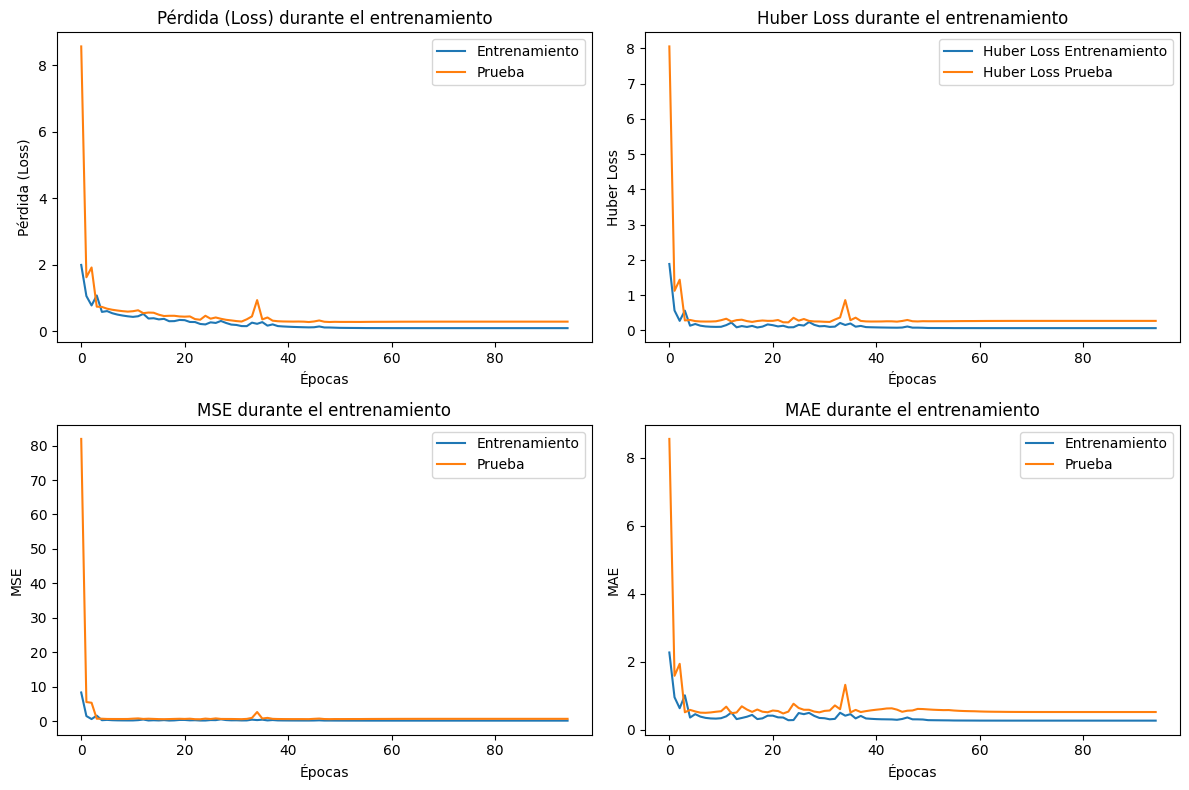

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


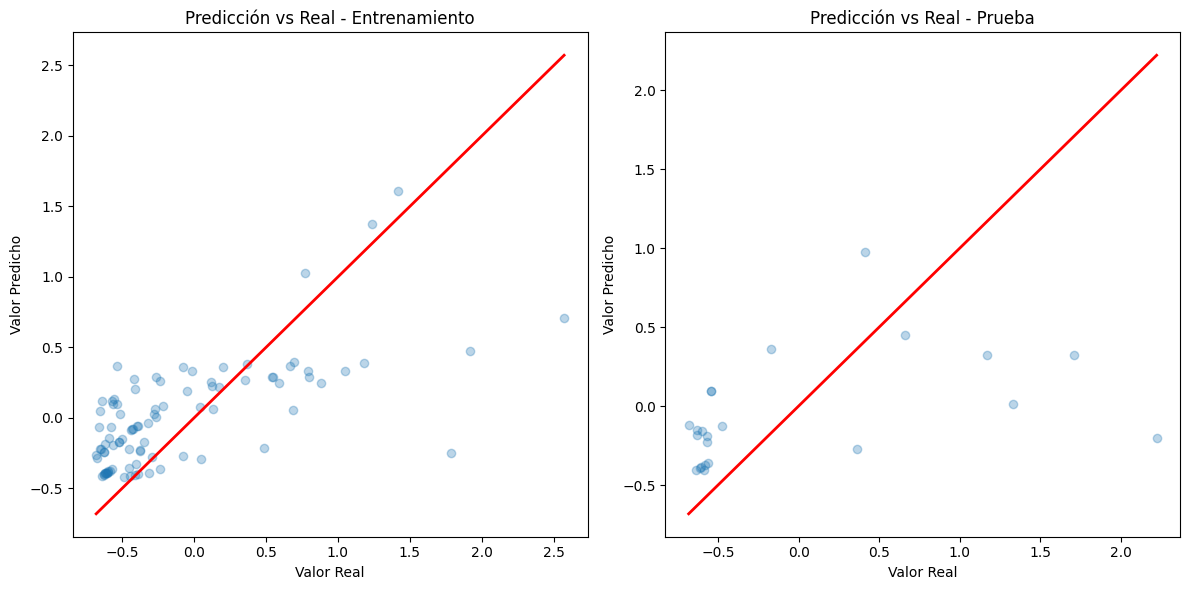

Simulación de cross_val_score (MSE): 0.26938920008182643 ± 0.17454839853828452
Simulación de cross_val_score (RMSE): 0.49499236988243955 ± 0.15611455358163298
Simulación de cross_val_score (MAE): 0.34988135532100656 ± 0.13225539150666546
SSE promedio: 360.3232914173757
SAE promedio: 317.46302902240757
R^2 promedio: 0.4604581512203838, Desviación estándar: 0.22259668306420793
Correlación de Pearson promedio: 3.113516745317963e-17, Desviación estándar: 1.1628478077132045e-16
Correlación de Spearman promedio: 0.6418582716053696, Desviación estándar: 0.0709741800614624
Huber Loss promedio: 0.0723975382745266, Desviación estándar: 0.02273419119667241
El punto de convergencia (mejor epoch): 45


In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo con los datos del pliegue actual
    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_3']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_4']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    model.compile(optimizer=RMSprop(best_params['learning_rate']),#------------------------------------
                  loss=tf.keras.losses.Huber(),                      #---------------------
                  metrics=['mae', 'mse', sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000, #--------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir con el modelo en el conjunto de validación
    y_pred = model.predict(X_val)

    # Calcular las métricas de error
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    sse = np.sum((y_val - y_pred) ** 2)
    sae = np.sum(np.abs(y_val - y_pred))
    r2 = r2_score(y_val, y_pred)
    pearson = pearson_correlation(y_val, y_pred).numpy()
    spearman, _ = spearmanr(y_val, y_pred)
    huber_loss = history.history['huber_loss'][-1]

    # Almacenar las métricas en las listas
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    sse_scores.append(sse)
    sae_scores.append(sae)
    r2_scores.append(r2)
    pearson_scores.append(pearson)
    spearman_scores.append(spearman)
    huber_loss_scores.append(huber_loss)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Prueba')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Prueba')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")